In [79]:
import os
import numpy as np
import pandas as pd
import cv2
import imageio
import matplotlib.pyplot as plt
import imageio
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras import models, layers

print("tf version: {}".format(tf.__version__))
%matplotlib inline

tf version: 2.10.0


In [80]:
def bin_img(img_p, treshold= 0.4545):
    img = imageio.imread(img_p)
    img = img.astype(np.float32) / 255.
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    
    img_bw = np.mean(img, axis=2)
    img_bin = (img_bw > treshold).astype(np.uint8)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_bin*255, cmap='gray')

In [81]:
IMG_SIZE = 224
BATCH = 18

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)
classes = train_ds.class_names

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/valid',
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    shuffle = True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH
)

Found 4101 files belonging to 7 classes.
Found 1753 files belonging to 7 classes.
Found 2603 files belonging to 7 classes.


In [82]:
classes

['carcinoma',
 'dermatofibroma',
 'keratosis',
 'melanoma',
 'nevus',
 'seborrheic_keratosis',
 'vascular_lesions']

(18, 224, 224, 3)


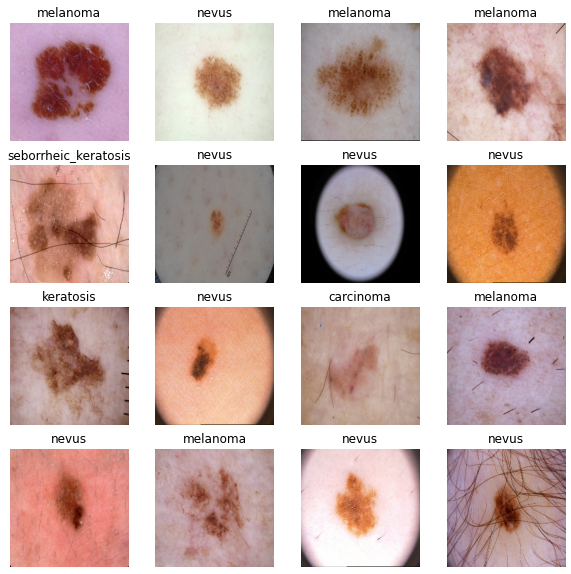

In [83]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [84]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [85]:
num_classes = len(classes)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [86]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [87]:
df_base = pd.DataFrame(columns=["model","loss","accuracy","val_loss","val_accuracy"])

In [88]:
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=20
# )

In [90]:
for i in range(1,5, 1):
    dict_= {}
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
    )
    name_model = 'model' + f"_epochs_{i}"
    dict_['model'] = name_model
    dict_['loss'] = round(history.history['loss'][0],4)
    dict_['accuracy'] = round(history.history['accuracy'][0],4)
    dict_['val_loss'] = round(history.history['val_loss'][0],4)
    dict_['val_accuracy'] = round(history.history['val_accuracy'][0],4)
    
    df_base = df_base.append(dict_,ignore_index=True)
    df_base.to_csv("df_base.csv")
    if i % 10 == 0:
        model.save(name_model)
    
            

228/228 [==============================] - 125s 541ms/step - loss: 1.3696 - accuracy: 0.4565 - val_loss: 1.9033 - val_accuracy: 0.2601


INFO:tensorflow:Assets written to: model_epochs_1\assets


INFO:tensorflow:Assets written to: model_epochs_1\assets


228/228 [==============================] - 100s 440ms/step - loss: 1.1402 - accuracy: 0.5616 - val_loss: 2.0435 - val_accuracy: 0.2995


INFO:tensorflow:Assets written to: model_epochs_2\assets


INFO:tensorflow:Assets written to: model_epochs_2\assets


228/228 [==============================] - 99s 433ms/step - loss: 1.0601 - accuracy: 0.5862 - val_loss: 2.2809 - val_accuracy: 0.2772


INFO:tensorflow:Assets written to: model_epochs_3\assets


INFO:tensorflow:Assets written to: model_epochs_3\assets


228/228 [==============================] - 99s 434ms/step - loss: 0.9702 - accuracy: 0.6250 - val_loss: 1.8353 - val_accuracy: 0.3092


INFO:tensorflow:Assets written to: model_epochs_4\assets


INFO:tensorflow:Assets written to: model_epochs_4\assets


In [91]:
# a = {"model":112,"loss":1,"accuracy":2,"val_loss":3,"val_accuracy":4}
# df_base = df_base.append(a,ignore_index=True)
df_base.head()

model    loss  accuracy  val_loss  val_accuracy
0  model_epochs_1  1.3696    0.4565    1.9033        0.2601
1  model_epochs_2  1.1402    0.5616    2.0435        0.2995
2  model_epochs_3  1.0601    0.5862    2.2809        0.2772
3  model_epochs_4  0.9702    0.6250    1.8353        0.3092

In [62]:
list(df_base['loss'][df_base["model"] == 112])[0]

1

In [28]:
print(round(history.history['loss'][0],4))

0.3061


In [9]:
score = model.evaluate(test_ds)

34/34 [==============================] - 17s 399ms/step - loss: 1.7968 - accuracy: 0.5333


In [68]:
def test_digit(sample):
    
    prediction = model(sample[None, ...])[0]
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0])
    plt.xticks([]), plt.yticks([])
    print("prediction: ", prediction)
    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(3), prediction, align='center')
#     bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted number: {}'.format(ans))

In [52]:
def prepare_image(fpath):

    img = imageio.imread(fpath, pilmode="RGB")
#     img = img.astype(np.float32)/255
    img = resize(img, (224, 224), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
#     img = np.mean(img, axis=2)
    img = np.reshape(img, (224, 224, 3))
    return img

In [11]:
df = pd.read_csv("train.csv")

In [75]:
df[df['target'] == "seborrheic_keratosis"]

path          img_name                target
1746  data/train/seborrheic_keratosis  ISIC_0012090.jpg  seborrheic_keratosis
1747  data/train/seborrheic_keratosis  ISIC_0012103.jpg  seborrheic_keratosis
1748  data/train/seborrheic_keratosis  ISIC_0012117.jpg  seborrheic_keratosis
1749  data/train/seborrheic_keratosis  ISIC_0012155.jpg  seborrheic_keratosis
1750  data/train/seborrheic_keratosis  ISIC_0012170.jpg  seborrheic_keratosis
...                               ...               ...                   ...
1995  data/train/seborrheic_keratosis  ISIC_0015182.jpg  seborrheic_keratosis
1996  data/train/seborrheic_keratosis  ISIC_0015220.jpg  seborrheic_keratosis
1997  data/train/seborrheic_keratosis  ISIC_0015233.jpg  seborrheic_keratosis
1998  data/train/seborrheic_keratosis  ISIC_0015260.jpg  seborrheic_keratosis
1999  data/train/seborrheic_keratosis  ISIC_0015295.jpg  seborrheic_keratosis

[254 rows x 3 columns]

In [14]:
df['target'].value_counts()

nevus                   1372
melanoma                 374
seborrheic_keratosis     254
Name: target, dtype: int64

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  This is separate from the ipykernel package so we can avoid doing imports until


prediction:  tf.Tensor([ 46.648518  18.330761 -68.94    ], shape=(3,), dtype=float32)


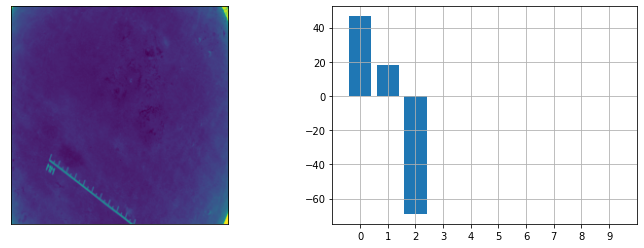

Predicted number: 0


In [76]:
img = prepare_image("data/train/seborrheic_keratosis/ISIC_0012090.jpg")
test_digit(img)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # This is added back by InteractiveShellApp.init_path()


(767, 1022, 3)
(767, 1022, 3)
(767, 1022, 3)
(1129, 1504, 3)
(1129, 1504, 3)
(1129, 1504, 3)
(1129, 1503, 3)
(1129, 1504, 3)
(1129, 1504, 3)
(1129, 1504, 3)


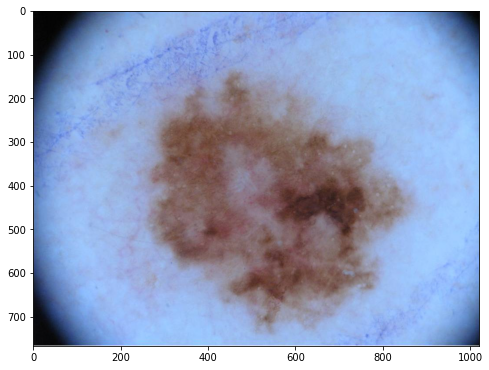

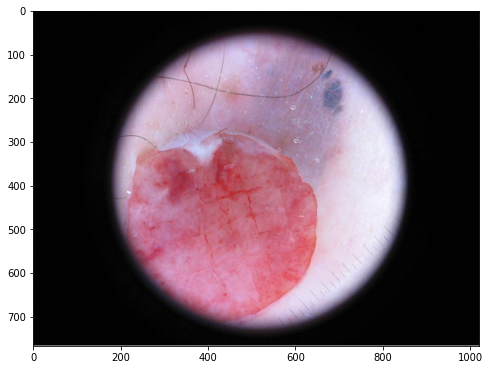

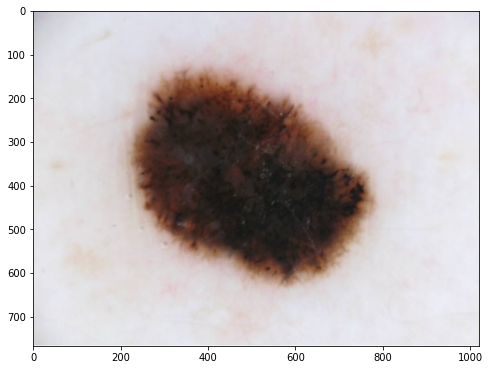

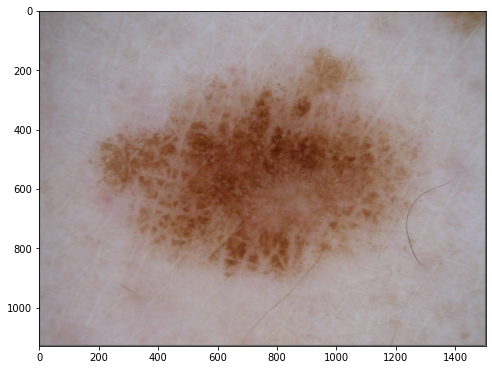

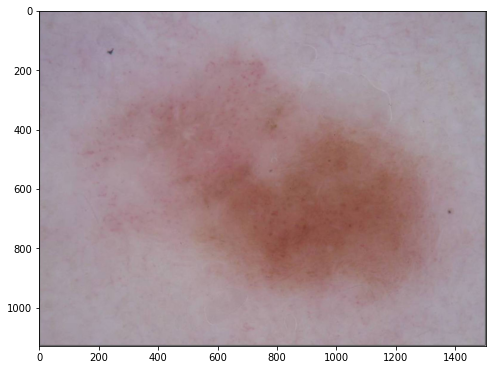

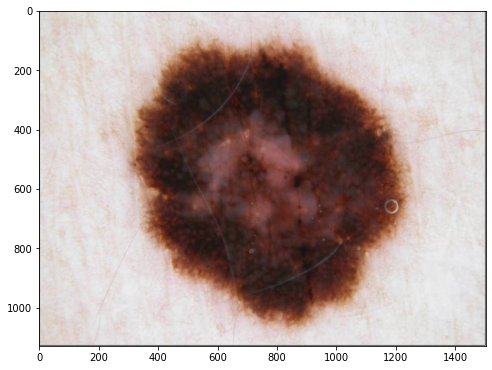

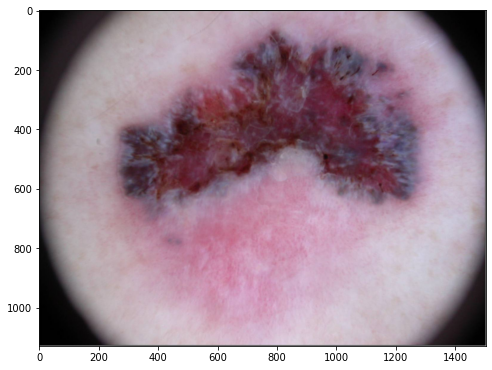

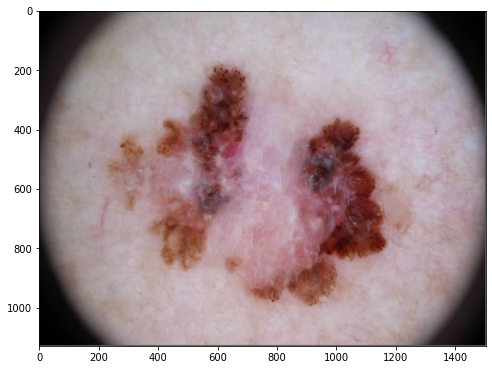

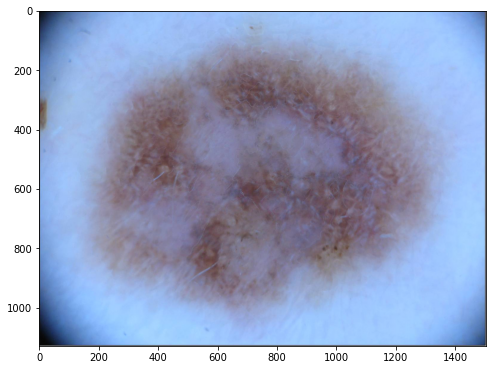

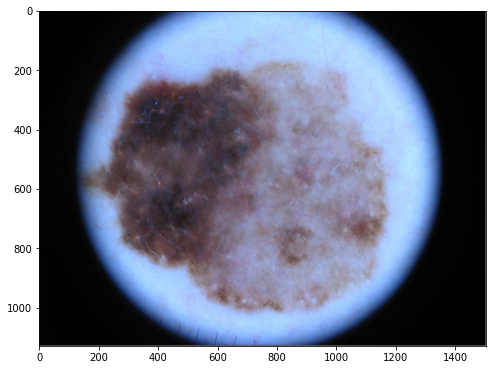

In [16]:
count = 10
target = 'melanoma'
for i in df.iterrows():
    if count == 0:
        break
    if i[1][2] == target:
        p = i[1][0]
        n = i[1][1]
        count -= 1
        img_n = p + "\\" + n
        img = imageio.imread(img_n)
        img = img.astype(np.float32) / 255.
        print(img.shape)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # This is added back by InteractiveShellApp.init_path()


(767, 1022, 3) nevus
(767, 1022, 3) nevus
(767, 1022, 3) nevus
(767, 1022, 3) nevus
(767, 1022, 3) nevus
(767, 1022, 3) nevus
(767, 1022, 3) nevus
(767, 1022, 3) nevus
(767, 1022, 3) nevus
(767, 1022, 3) nevus


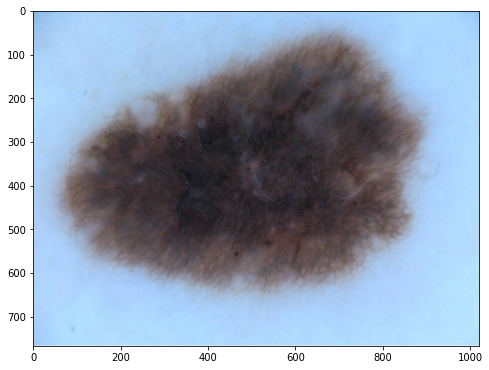

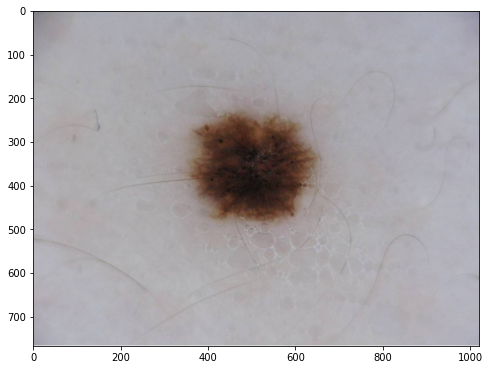

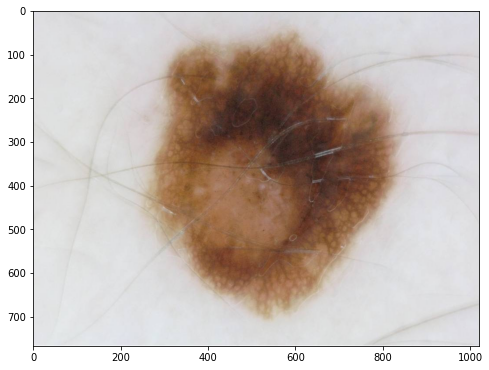

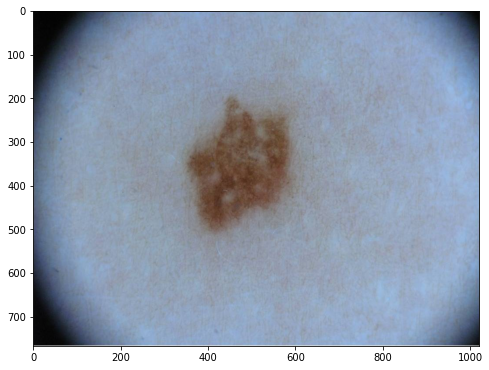

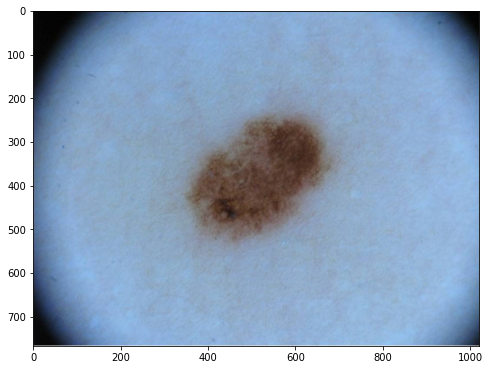

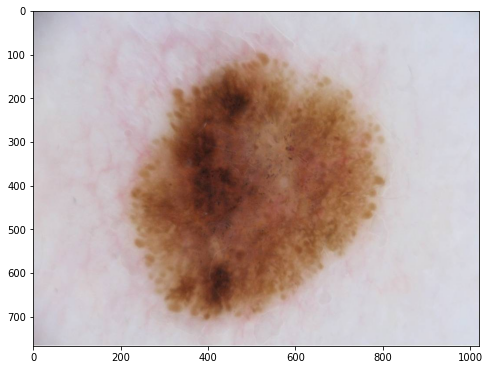

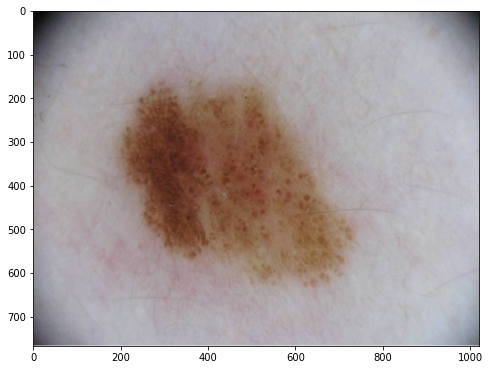

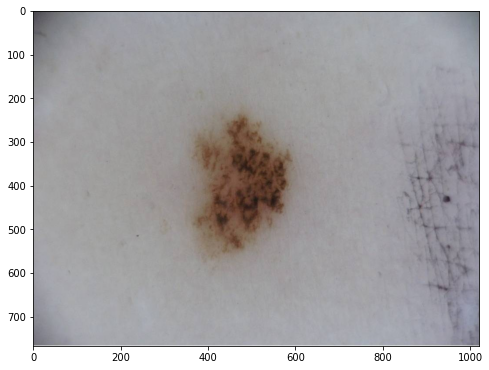

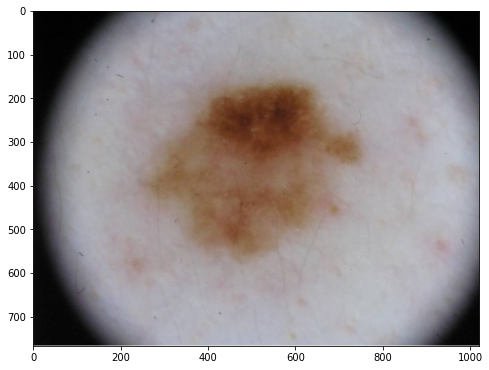

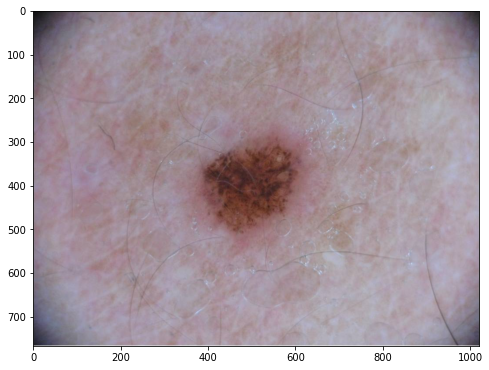

In [18]:
count = 10
target = 'nevus'
for i in df.iterrows():
    if count == 0:
        break
    if i[1][2] == target:
        p = i[1][0]
        n = i[1][1]
        count -= 1
        img_n = p + "\\" + n
        img = imageio.imread(img_n)
        img = img.astype(np.float32) / 255.
        print(img.shape, i[1][2])
        plt.figure(figsize=(8, 8))
        plt.imshow(img)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  # This is added back by InteractiveShellApp.init_path()


(2848, 4288, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis
(2000, 3008, 3) seborrheic_keratosis


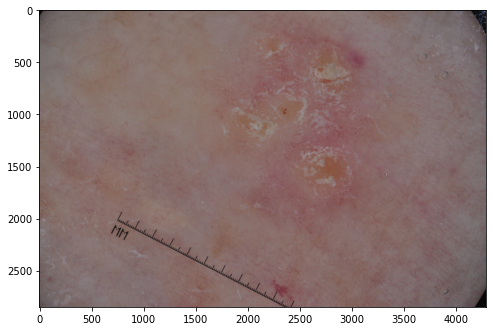

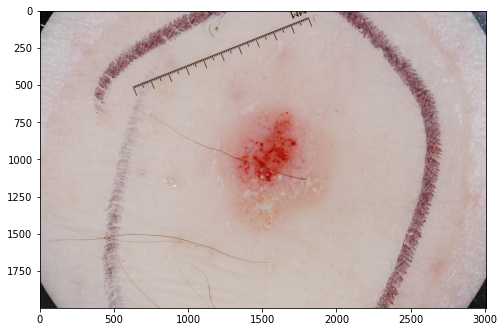

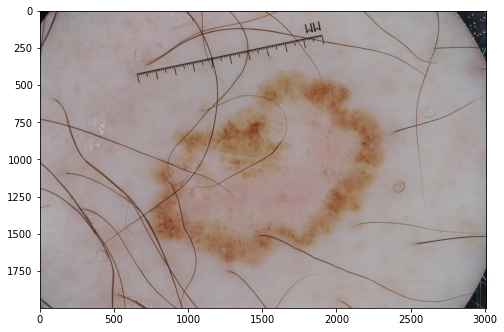

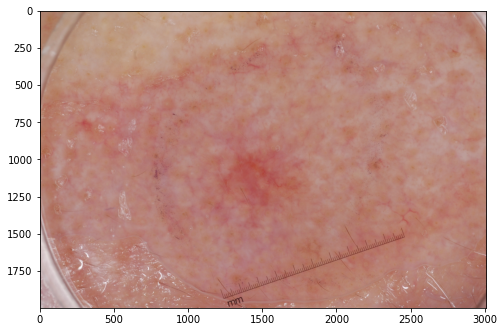

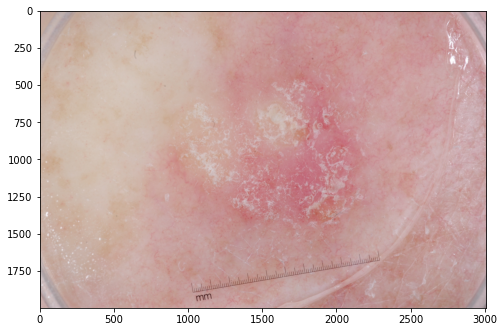

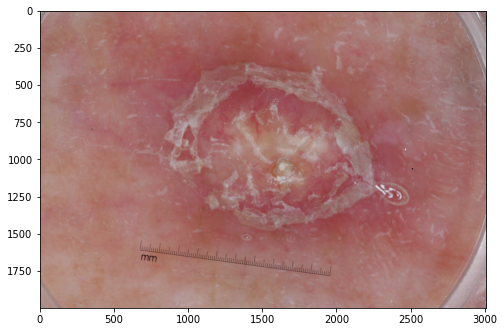

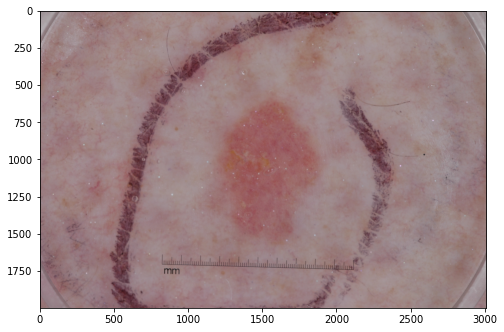

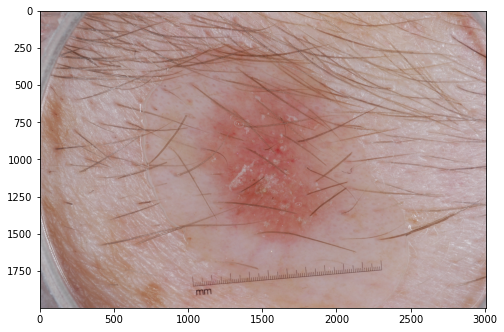

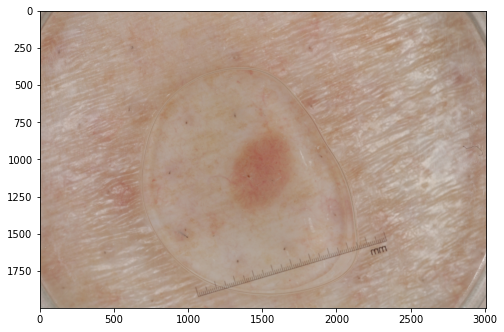

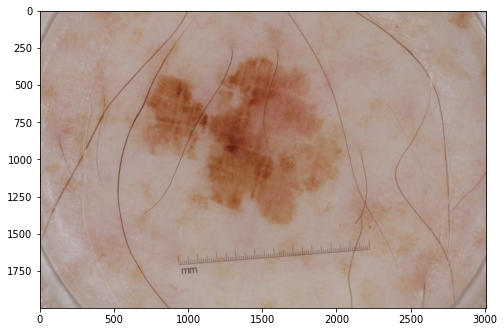

In [19]:
count = 10
target = 'seborrheic_keratosis'
for i in df.iterrows():
    if count == 0:
        break
    if i[1][2] == target:
        p = i[1][0]
        n = i[1][1]
        count -= 1
        img_n = p + "\\" + n
        img = imageio.imread(img_n)
        img = img.astype(np.float32) / 255.
        print(img.shape, i[1][2])
        plt.figure(figsize=(8, 8))
        plt.imshow(img)